In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os 
import numpy as np

from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


from scipy.stats import pearsonr
import ccxt
import warnings
import seaborn as sns

import pytrendseries

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
eth_5min = pd.read_parquet(r"C:\Users\tariq\algorithmic_trading\5min_perp\ETH_USDT_USDT.parquet")
# eth_5min["ret"] = eth_5min["close"].pct_change()
# eth_5min["buyhold"] = (1 + eth_5min["ret"]).cumprod() - 1
eth_5min["close"] = eth_5min["close"]
eth_5min["Date"] = pd.to_datetime(eth_5min["date"]) 
eth_5min.set_index("Date", inplace=True)


In [127]:
def add_trend_to_data(window, data, trend="uptrend"):
    up_trends = pytrendseries.detecttrend(data["close"].to_frame(), trend=trend, window=window)
    data[f"trend_{window}"] = None

    for _, row in up_trends.iterrows():
        idx_from = int(row["index_from"])
        idx_to = int(row["index_to"])
        data.iloc[idx_from:idx_to + 1, data.columns.get_loc(f"trend_{window}")] = trend
    return data


In [159]:
data_resampled = eth_5min.resample('1H').agg({'close': 'last'})
#720 heures pour 30 jours
up_trends = pytrendseries.detecttrend(data_resampled["close"].to_frame(), window=24, trend="uptrend")

Trends detected in 1.75 secs


In [160]:
eth_5min['trend_1h'] = None  
up_trends['from'] = pd.to_datetime(up_trends['from'])
up_trends['to'] = pd.to_datetime(up_trends['to'])

for _, row in up_trends.iterrows():
    date_from = (row["from"])
    date_to = (row["to"])
    eth_5min.loc[(eth_5min.index >= date_from) & (eth_5min.index <= date_to), 'trend_1h'] = "uptrend"


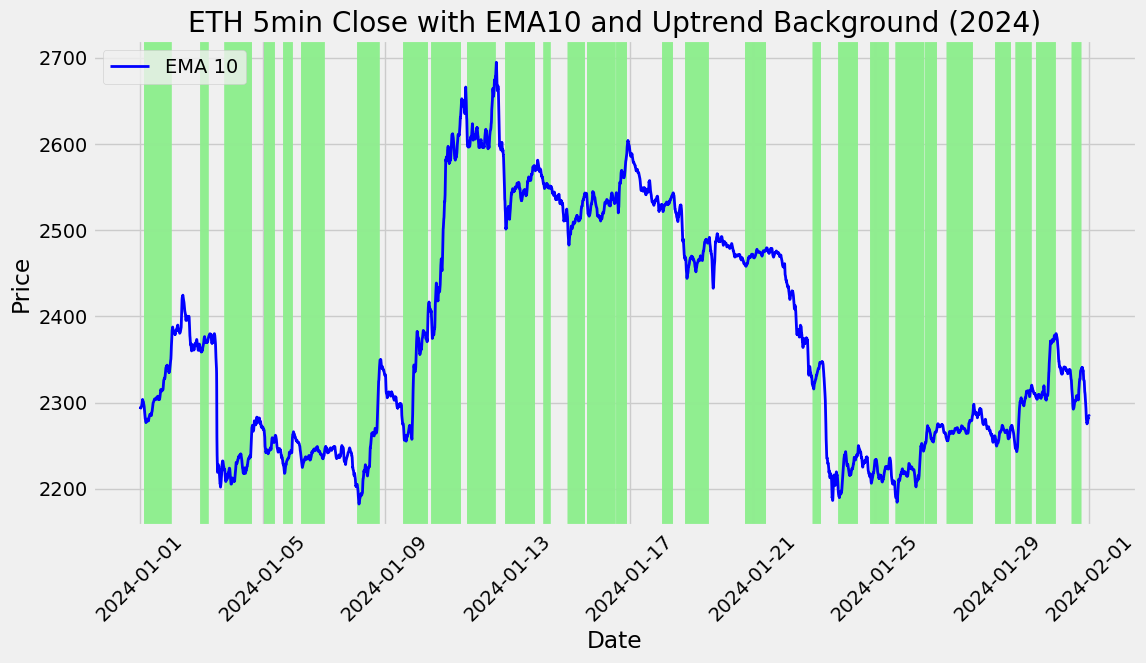

In [161]:
import matplotlib.pyplot as plt

# Filtrer les données pour ne prendre que celles de 2024
eth_5min_2024 = eth_5min[ (eth_5min.index > datetime(2024, 1, 1)) & (eth_5min.index < datetime(2024, 2, 1)) ]

# Calcul de l'EMA à 10 périodes sur les données de 'eth_5min_2024'
eth_5min_2024['ema_10'] = eth_5min_2024['close'].ewm(span=10, adjust=False).mean()

# Configuration du graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer la tendance (uptrend en vert)
for i in range(1, len(eth_5min_2024)):
    if eth_5min_2024['trend_1h'][i] == 'uptrend':
        ax.axvspan(eth_5min_2024.index[i-1], eth_5min_2024.index[i], color='lightgreen', alpha=0.5)

# Tracer l'EMA à 10 périodes
ax.plot(eth_5min_2024.index, eth_5min_2024['ema_10'], label='EMA 10', color='blue', lw=2)

# Ajouter des labels et une légende
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('ETH 5min Close with EMA10 and Uptrend Background (2024)')

# Afficher la légende
ax.legend()

# Afficher le graphique
plt.xticks(rotation=45)
plt.show()


In [177]:
eth_5min

,date,open,high,low,close,...,open_next,close_after,fee_buy,fee_sell,return
Date,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,129.12000,129.12000,128.76000,128.81000,...,128.78000,128.87000,0.12878,0.12887,0.00070
2020-01-01 00:05:00,2020-01-01 00:05:00,128.78000,128.94000,128.65000,128.87000,...,128.90000,128.87000,0.12890,0.12887,-0.00023
2020-01-01 00:10:00,2020-01-01 00:10:00,128.90000,128.92000,128.77000,128.87000,...,128.88000,128.82000,0.12888,0.12882,-0.00047
2020-01-01 00:15:00,2020-01-01 00:15:00,128.88000,128.99000,128.77000,128.82000,...,128.81000,128.67000,0.12881,0.12867,-0.00109
2020-01-01 00:20:00,2020-01-01 00:20:00,128.81000,128.85000,128.66000,128.67000,...,128.68000,128.75000,0.12868,0.12875,0.00054
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-29 23:30:00,2025-03-29 23:30:00,1820.64000,1820.90000,1818.18000,1819.43000,...,1819.43000,1822.09000,1.81943,1.82209,0.00146
2025-03-29 23:35:00,2025-03-29 23:35:00,1819.43000,1822.42000,1819.00000,1822.09000,...,1822.08000,1823.15000,1.82208,1.82315,0.00059
2025-03-29 23:40:00,2025-03-29 23:40:00,1822.08000,1823.82000,1821.80000,1823.15000,...,1823.14000,1824.76000,1.82314,1.82476,0.00089


In [247]:
def backtest_extreme_candle_pair(df, threshold=-0.01, fee=True, trend=None):

    df["date"] = pd.to_datetime(df["date"])
    
    df["ret"] = df["close"].pct_change()
    df["logreturn_1"] = df["ret"].shift(1) 
    df["buy_hold_ret"] = (1 + df["ret"]).cumprod() - 1

    # signaux
    if trend == "uptrend":
        signal_mask = (df["ret"] > threshold) & (df["trend_1h"] == "uptrend")
    else:
        signal_mask = df["ret"] > threshold

    # Shift pour avoir accès aux données futures
    df["open_next"] = df["open"].shift(-1)
    df["close_after"] = df["close"].shift(-1)


    df["fee_buy"] = df["open_next"] * 0.001
    df["fee_sell"] = df["close_after"] * 0.001

    if fee :
        df["return"] = (df["close_after"] - df["open_next"] - df["fee_buy"] - df["fee_sell"]) / df["open_next"]
    else:
        df["return"] = (df["close_after"] - df["open_next"]) / df["open_next"]

    trades = df[signal_mask].copy()
    trades["timestamp"] = trades["date"]

    trades = trades[[ "timestamp", "open_next", "close_after", "return", "buy_hold_ret"]]

    if not trades.empty:
        trades["cumulative_return"] = (1 + trades["return"]).cumprod() - 1
    else:
        print(f"Aucun trade détecté")

    return trades

def backtest_tp_sl(df, threshold=-0.01, take_profit=0.01, stop_loss=0.005, fee=True, trend=None):
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    df["ret"] = df["close"].pct_change()
    
    if trend == "uptrend":
        signal_mask = (df["ret"] > threshold) & (df["trend_1h"] == "uptrend")
    else:
        signal_mask = df["ret"] > threshold

    signals = df[signal_mask].index
    trades = []

    print(f"Nombre de signaux : {len(signals)}")
    trades = []

    for idx in signals:
        entry_idx = idx + 1
        if entry_idx not in df.index:
            continue

        entry_price = df.loc[entry_idx, "open"]
        fee_entry = entry_price * 0.001 if fee else 0

        for next_idx in df.index[entry_idx + 1:]:
            
            high = df.loc[next_idx, "high"]
            low = df.loc[next_idx, "low"]

            hit_tp = (high - entry_price) / entry_price >= take_profit
            hit_sl = (low - entry_price) / entry_price <= stop_loss

            tp_sl_ambiguous = hit_tp and hit_sl
            
            exit_price = None
            exit_reason = None
            fee_exit = 0

            # SL prioritaire
            if hit_sl:
                exit_price = entry_price * (1 + stop_loss)
                exit_reason = "SL"
                fee_exit = exit_price * 0.001 if fee else 0

            elif hit_tp:
                exit_price = entry_price * (1 + take_profit)
                exit_reason = "TP"
                fee_exit = exit_price * 0.001 if fee else 0

            if exit_price is not None:
                return_pct = (
                    (exit_price - entry_price - fee_entry - fee_exit) / entry_price
                    if fee else
                    (exit_price - entry_price) / entry_price
                )
                trades.append({
                    "timestamp": df.loc[entry_idx, "date"],
                    "entry": entry_price,
                    "exit": exit_price,
                    "exit_date": df.loc[next_idx, "date"], 
                    "return": return_pct,
                    "exit_reason": exit_reason,
                    "buy_hold_ret": df.loc[next_idx, "buy_hold_ret"],
                    "tp_sl": tp_sl_ambiguous 
                })
                break 

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df["cumulative_return"] = (1 + trades_df["return"]).cumprod() - 1
    else:
        print(f"Aucun trade avec TP/SL")

    return trades_df

In [248]:
trades_uptrend = backtest_extreme_candle_pair(eth_5min, threshold=0.0025, fee=False, trend="uptrend")
trades = backtest_extreme_candle_pair(eth_5min, threshold=0.005, fee=False, trend=None)

In [ ]:
trades_uptrend_tp_sl = backtest_tp_sl(eth_5min, threshold=0.0025, take_profit=0.01, stop_loss=-0.01, fee=True, trend="uptrend")

Nombre de signaux : 29848


In [251]:
trades_uptrend_tp_sl

,timestamp,entry,exit,exit_date,return,exit_reason,buy_hold_ret,tp_sl,cumulative_return
0,2020-01-01 01:25:00,129.62000,130.91620,2020-01-01 02:00:00,0.00799,TP,0.01227,False,0.00799
1,2020-01-01 01:30:00,130.22000,131.52220,2020-01-01 11:20:00,0.00799,TP,0.02236,False,0.01604
2,2020-01-01 02:00:00,130.58000,131.88580,2020-01-01 13:00:00,0.00799,TP,0.02197,False,0.02416
3,2020-01-01 04:35:00,130.48000,131.78480,2020-01-01 11:20:00,0.00799,TP,0.02236,False,0.03235
4,2020-01-01 11:25:00,131.69000,130.37310,2020-01-01 22:05:00,-0.01199,SL,0.01211,False,0.01997
...,...,...,...,...,...,...,...,...,...
29843,2025-03-28 17:20:00,1875.45000,1894.20450,2025-03-28 22:50:00,0.00799,TP,13.72712,False,2456659782001.26416
29844,2025-03-28 19:10:00,1882.24000,1901.06240,2025-03-28 22:55:00,0.00799,TP,13.75359,False,2476288493659.46191
29845,2025-03-28 20:05:00,1880.00000,1898.80000,2025-03-28 22:55:00,0.00799,TP,13.75359,False,2496074038723.80908
29846,2025-03-28 21:10:00,1882.63000,1901.45630,2025-03-29 00:10:00,0.00799,TP,13.76958,False,2516017670293.22021


<Axes: title={'center': 'Cumulative Return of Trades (Uptrend)'}, xlabel='timestamp'>

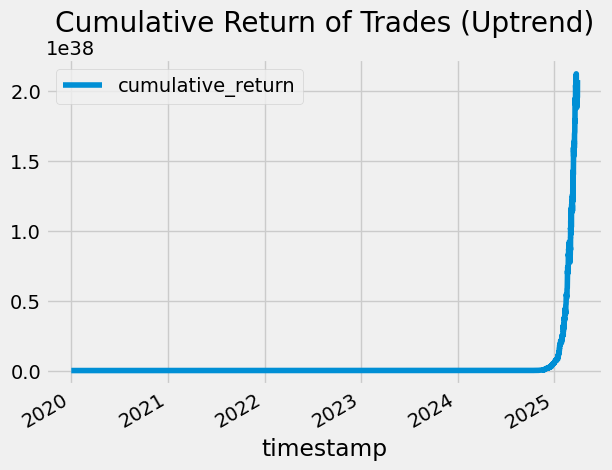

In [253]:
trades_uptrend_tp_sl.plot(x="timestamp", y="cumulative_return", title="Cumulative Return of Trades (Uptrend)")
# trades.plot(x="timestamp", y="cumulative_return", title="Cumulative Return of Trades (All)")

<Axes: title={'center': 'Cumulative Return of Trades (All)'}, xlabel='timestamp'>

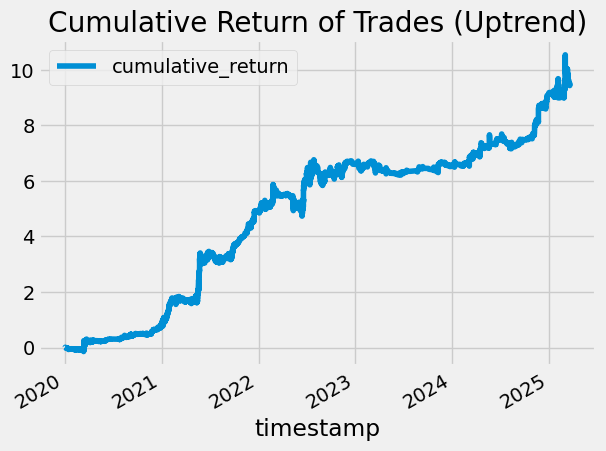

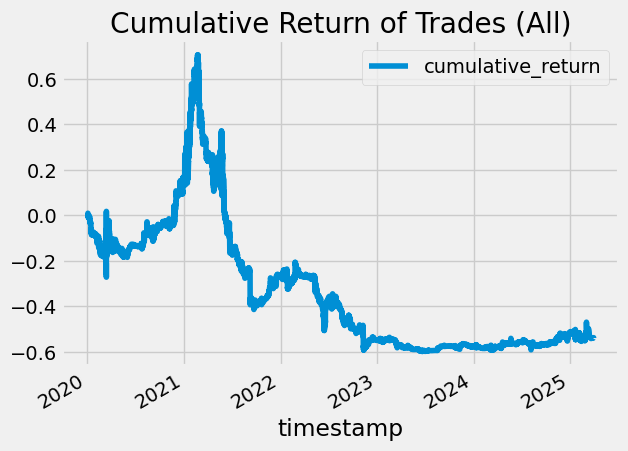

In [235]:
figsize = (12, 6)

trades_uptrend = backtest_extreme_candle_pair(eth_5min, threshold=0.005, fee=False, trend="uptrend")
trades = backtest_extreme_candle_pair(eth_5min, threshold=0.005, fee=False, trend=None)

trades_uptrend.plot(x="timestamp", y="cumulative_return", title="Cumulative Return of Trades (Uptrend)")
trades.plot(x="timestamp", y="cumulative_return", title="Cumulative Return of Trades (All)")